PID controller

In [78]:
import numpy as np

class PIDController:
    """
    PID controller for LunarLander with continuous action mapping
    """
    def __init__(self, params):
        # params = [kp_alt, kd_alt, kp_ang, kd_ang]
        self.kp_alt = params[0]
        self.kd_alt = params[1]
        self.kp_ang = params[2]  # This should be NEGATIVE for stability
        self.kd_ang = params[3]
        
        # Action thresholds (tunable)
        self.alt_threshold = 0.3
        self.ang_threshold = 0.15
        
    def get_action(self, state):
        """
        state: [x, y, vel_x, vel_y, angle, ang_vel, leg1, leg2]
        returns: int (0, 1, 2, 3)
        """
        y_pos = state[1]
        y_vel = state[3]
        angle = state[4]
        ang_vel = state[5]
        
        # Target descent velocity (negative for descending)
        target_y_vel = -0.5
        
        # Vertical control: PD for altitude
        alt_error = target_y_vel - y_vel
        alt_todo = self.kp_alt * alt_error + self.kd_alt * (0 - y_pos)
        
        # Angular control: PD for angle (keep upright at 0 radians)
        ang_error = 0 - angle  # Want angle = 0
        ang_todo = self.kp_ang * ang_error + self.kd_ang * (0 - ang_vel)
        
        # Action selection with hysteresis
        # Priority: orientation first, then altitude
        
        # If angle is significantly off, correct it
        if abs(ang_todo) > self.ang_threshold:
            if ang_todo > 0:
                return 1  # Fire left engine (rotate clockwise)
            else:
                return 3  # Fire right engine (rotate counter-clockwise)
        
        # If vertical control requires action
        if alt_todo > self.alt_threshold:
            return 2  # Fire main engine (upward thrust)
        
        # Default: do nothing
        return 0

Evaluate params

In [79]:
import gymnasium as gym
import numpy as np

def evaluate_parameters(params, n_runs=3, render=False):
    """
    Evaluate PID parameters with multiple runs for stability
    
    params: [kp_alt, kd_alt, kp_ang, kd_ang]
    n_runs: number of episodes to average over
    render: whether to show visualization
    
    returns: average score
    """
    render_mode = "human" if render else None
    env = gym.make("LunarLander-v3", render_mode=render_mode)
    
    scores = []
    
    for run in range(n_runs):
        agent = PIDController(params)
        
        # Different seed for each run to cover different initial conditions
        state, _ = env.reset(seed=run)
        
        total_reward = 0
        terminated = False
        truncated = False
        
        while not (terminated or truncated):
            action = agent.get_action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
        
        scores.append(total_reward)
        
        # # Debug output for first few runs
        # if run == 0 and not render:
        #     print(f"  Params {params}: Run {run+1} = {total_reward:.1f}")
    
    env.close()
    
    avg_score = np.mean(scores)
    # if n_runs > 1:
    #     std_score = np.std(scores)
    #     print(f"  Avg: {avg_score:.1f} ± {std_score:.1f} over {n_runs} runs")
    
    return float(avg_score)

BayesOpt model

In [80]:
import torch
import botorch
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import LogExpectedImprovement
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.utils.transforms import standardize # deal with large score from agent. GP works well for small y's, heuristically [-2, 2]
from botorch.models.transforms import Normalize # small x input is good too (0->1)

DTYPE = torch.double

class BayesianOptimizer():
    def __init__(self, bounds, n_init=20):
        """
        bounds: torch.tensor of shape (2, d) where d=4
                bounds[0] = lower bounds, bounds[1] = upper bounds
        n_init: number of initial random samples
        """
        self.bounds = bounds
        d = bounds.shape[1]
        
        # generate initial samples within bounds
        self.train_x = torch.rand(n_init, d, dtype=DTYPE) * (bounds[1] - bounds[0]) + bounds[0]
        self.train_y = torch.zeros(n_init, 1, dtype=DTYPE)
        
        # evaluate each initial sample (average multiple runs for stability)
        for i in range(n_init):
            params_list = self.train_x[i].tolist()
            # ese average of 3 runs to reduce noise
            score = evaluate_parameters(params=params_list, n_runs=3, render=False)
            self.train_y[i] = score


            
    
    # one iteration - returns candidate
    def update_posterior(self, x_new = None, y_new = None):
        
        if(x_new is not None and y_new is not None):
            # concatenate
            self.train_x = torch.cat([self.train_x, x_new], dim=0)
            self.train_y = torch.cat([self.train_y, y_new], dim=0)

        # init

        # don't forget to STANDARDIZE y and NORMALIZE x for faster convergence
        gp = SingleTaskGP(
            self.train_x, 
            standardize(self.train_y), 
            input_transform=Normalize(d=self.train_x.shape[-1])
        )
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

        # update posterior
        fit_gpytorch_mll(mll) # already have some initial random data so ok

        # try log expected
        best_value = self.train_y.max()
        EI = LogExpectedImprovement(gp, best_f=best_value)
        
        
        candidate, acquisition_score = optimize_acqf(
            acq_function=EI,
            bounds=self.bounds,
            q=1,
            num_restarts=10,
            raw_samples=512,
            sequential=False  # Better for noisy objectives
        )
        
        return candidate



In [81]:
# --- EXPERIMENT SETTINGS ---
N_RUNS = 5          # Number of repetitions
N_ITERS = 80        # Optimization steps per run (reduced for speed)
MIN_VAL = [0.0, 0.0, -20.0, 0.0]    # kp_ang should be negative
MAX_VAL = [30.0, 5.0, 0.0, 3.0]      # different ranges per parameter
SEED_OFFSET = 42

# Convert to tensor for BoTorch
bounds = torch.tensor([MIN_VAL, MAX_VAL], dtype=torch.double)

Functions for running experiments

In [82]:
def run_benchmark_bo(n_iters, seed): 
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    print(f"  Starting BO with {seed}...")
    
    # Initialize BO with 20 samples and proper bounds
    b_opt = BayesianOptimizer(bounds=bounds, n_init=20)
    
    rewards_history = []
    
    # Add initial random samples
    initial_rewards = b_opt.train_y.flatten().tolist()
    rewards_history.extend(initial_rewards)
    
    prev_candidate = None
    prev_score = None
    
    # Optimization loop
    for i in range(n_iters):
        candidate_tensor = b_opt.update_posterior(x_new=prev_candidate, y_new=prev_score)
        params = candidate_tensor.flatten().tolist()
        
        # Evaluate with 3 runs for stability
        score = evaluate_parameters(params, n_runs=3, render=False)
        rewards_history.append(score)
        
        # Update for next iteration
        prev_score = torch.tensor([[score]], dtype=torch.double)
        prev_candidate = candidate_tensor
        
        # Early stopping if we find good parameters
        if score > 200:
            print(f"    Found good solution! Score: {score}")
            break
    
    return rewards_history

def run_benchmark_random(n_iters, seed):
    np.random.seed(seed)
    print(f"  Starting Random with {seed}...")
    
    rewards_history = []
    total_evals = 20 + n_iters  # Match BO's initial + iterations
    
    for eval_num in range(total_evals):
        
        # Sample each parameter within its specific bounds
        params = [
            np.random.uniform(MIN_VAL[0], MAX_VAL[0]),
            np.random.uniform(MIN_VAL[1], MAX_VAL[1]),
            np.random.uniform(MIN_VAL[2], MAX_VAL[2]),  # kp_ang will be negative
            np.random.uniform(MIN_VAL[3], MAX_VAL[3])
        ]
        
        # Evaluate with 3 runs
        score = evaluate_parameters(params, n_runs=3, render=False)
        rewards_history.append(score)
        
    return rewards_history

Running experiment

In [83]:
# Running the benchmark
bo_results = []
random_results = []

print(f"--- Starting Benchmark: {N_RUNS} runs, {N_ITERS} iters each ---")

for i in range(N_RUNS):
    print(f"\nRun {i+1}/{N_RUNS}")
    run_seed = SEED_OFFSET + i
    
    # Run BO
    print("  BO:")
    bo_trace = run_benchmark_bo(n_iters=N_ITERS, seed = run_seed)
    bo_results.append(bo_trace)
    
    # Run Random
    print("  Random:")
    random_trace = run_benchmark_random(N_ITERS, run_seed)
    random_results.append(random_trace)

print("\nBenchmark Complete!")

--- Starting Benchmark: 5 runs, 80 iters each ---

Run 1/5
  BO:
  Starting BO with 42...
  Random:
  Starting Random with 42...

Run 2/5
  BO:
  Starting BO with 43...
  Random:
  Starting Random with 43...

Run 3/5
  BO:
  Starting BO with 44...
  Random:
  Starting Random with 44...

Run 4/5
  BO:
  Starting BO with 45...
  Random:
  Starting Random with 45...

Run 5/5
  BO:
  Starting BO with 46...


c:\Users\Admin\miniconda3\envs\botorch-env\lib\site-packages\botorch\optim\optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
c:\Users\Admin\miniconda3\envs\botorch-env\lib\site-packages\botorch\optim\optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


  Random:
  Starting Random with 46...

Benchmark Complete!


Plot saved to results/optimization_trace_fixed.png


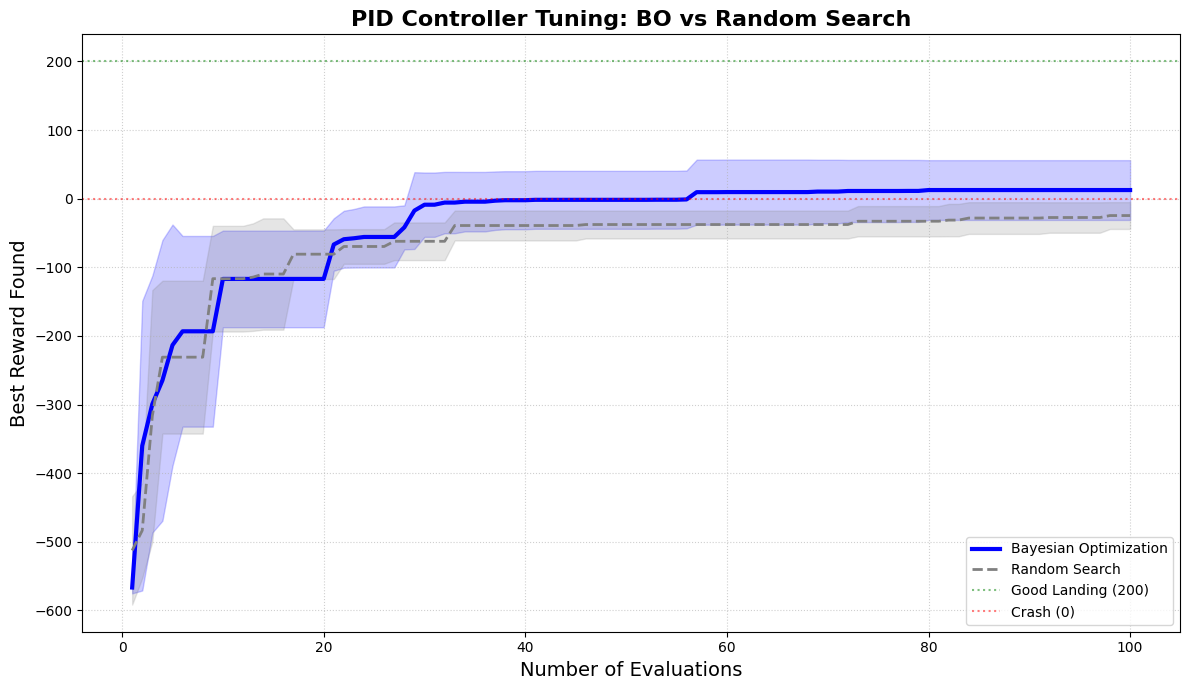

In [84]:
import matplotlib.pyplot as plt

# Analysis and plotting
def get_best_so_far(traces):
    processed_runs = []
    for trace in traces:
        best_run = []
        current_max = -float('inf')
        for reward in trace:
            if reward > current_max:
                current_max = reward
            best_run.append(current_max)
        processed_runs.append(best_run)
    return np.array(processed_runs)

# Process results
bo_best = get_best_so_far(bo_results)
random_best = get_best_so_far(random_results)

# Calculate statistics
bo_mean = np.mean(bo_best, axis=0)
bo_std = np.std(bo_best, axis=0)
rand_mean = np.mean(random_best, axis=0)
rand_std = np.std(random_best, axis=0)

# Create x-axis
x_axis = np.arange(1, len(bo_mean) + 1)

# Plotting
plt.figure(figsize=(12, 7))

# Plot with confidence intervals
plt.plot(x_axis, bo_mean, label='Bayesian Optimization', color='blue', linewidth=3)
plt.fill_between(x_axis, bo_mean - bo_std, bo_mean + bo_std, color='blue', alpha=0.2)

plt.plot(x_axis, rand_mean, label='Random Search', color='gray', linestyle='--', linewidth=2)
plt.fill_between(x_axis, rand_mean - rand_std, rand_mean + rand_std, color='gray', alpha=0.2)

# Style
plt.title("PID Controller Tuning: BO vs Random Search", fontsize=16, fontweight='bold')
plt.xlabel("Number of Evaluations", fontsize=14)
plt.ylabel("Best Reward Found", fontsize=14)
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, linestyle=':', alpha=0.6)

# Add horizontal line at 200 (good landing)
plt.axhline(y=200, color='green', linestyle=':', alpha=0.5, label='Good Landing (200)')
plt.axhline(y=0, color='red', linestyle=':', alpha=0.5, label='Crash (0)')

plt.legend(fontsize=10)
plt.tight_layout()

# Save
save_path = "results/optimization_trace_fixed.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to {save_path}")

plt.show()